# DT Assignment1 - 12기 김탁영

# Data Loading

In [4]:
import pandas as pd 
import numpy as np
from IPython.display import Image

In [5]:
pd_data = pd.read_csv('https://raw.githubusercontent.com/AugustLONG/ML01/master/01decisiontree/AllElectronics.csv')
pd_data.drop("RID",axis=1, inplace = True) #RID는 그냥 순서라서 삭제
pd_data

,age,income,student,credit_rating,class_buys_computer
0,youth,high,no,fair,no
1,youth,high,no,excellent,no
2,middle_aged,high,no,fair,yes
3,senior,medium,no,fair,yes
4,senior,low,yes,fair,yes
5,senior,low,yes,excellent,no
6,middle_aged,low,yes,excellent,yes
7,youth,medium,no,fair,no
8,youth,low,yes,fair,yes
9,senior,medium,yes,fair,yes


# 1. Gini 계수를 구하는 함수 만들기

- Input: df(데이터), label(타겟변수명)
- 해당 결과는 아래와 같이 나와야 합니다.

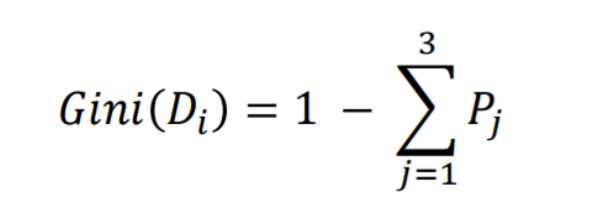

In [6]:
Image('get_gini.png') # get_gini 함수에 사용되는 공식 (Pj에 제곱 필요 - 그림 오타)

In [7]:
def get_gini(df, label): 
    class_total = df[label]         # 타겟변수 내 전체 데이터
    class_uniq = df[label].unique() # 타겟변수 내 고유 클래스의 집합

    gini = 1
    for each in class_uniq: # 위 공식에 맞게 지니계수를 계산한다. 
        gini += -(len(class_total.loc[class_total == each]) / len(class_total)) ** 2
    
    return gini    

In [8]:
get_gini(pd_data,'class_buys_computer')

0.4591836734693877

# 2. Feature의 Class를 이진 분류로 만들기
 ## ex) {A,B,C} -> ({A}, {B,C}), ({B}, {A,C}), ({C}, {A,B})

- Input: df(데이터), attribute(Gini index를 구하고자 하는 변수명)
- 해당 결과는 아래와 같이 나와야 합니다.

In [9]:
from itertools import combinations

def get_binary_split(df, attribute):
    class_uniq = df[attribute].unique() # 고유 클래스의 집합 (클래스가 하나뿐인 것은 무의미하기 때문에 길이가 2 이상이라 가정)
    
    result = []
    # Binary split을 전제로 하기 때문에 절반 길이의 조합만 구해도 나머지가 구해진다.
    for i in range(1, len(class_uniq)//2 + 1):
        combi = list(combinations(class_uniq, i)) # 각 항목이 n개로 이루어진 조합(부분집합)을 리스트로 만든다.
        
        for j in range(len(combi)): # (A,B)로 split된다고 가정하면 A를 먼저 결과에 저장한다.
            result.append(list(combi[j]))
        
        # 클래스가 2개인 경우에는 (1,1)로 나뉘어 B에 해당되는 나머지가 자동 저장되므로 따로 계산할 필요가 없다.
        if len(class_uniq) > 2:
            # 각각의 A에 대하여 A를 포함하지 않는(binary split된) 나머지인 B를 저장한다.
            for j in range(len(combi)):
                # 전체 조합에서 A 부분을 삭제한 나머지를 저장
                tmp = list(df[attribute].unique())
                for elm in list(combi[j]):
                    tmp.remove(elm)
                result.append(tmp)
                
    return result

In [10]:
get_binary_split(pd_data,'credit_rating') # 클래스가 2개인 경우

[['fair'], ['excellent']]

In [11]:
get_binary_split(pd_data,"age") # 클래스가 3개인 경우

[['youth'],
 ['middle_aged'],
 ['senior'],
 ['middle_aged', 'senior'],
 ['youth', 'senior'],
 ['youth', 'middle_aged']]

# 3. 다음은 모든 이진분류의 경우의 Gini index를 구하는 함수 만들기
- 위에서 완성한 두 함수를 사용하여 만들어주세요!
- 해당 결과는 아래와 같이 나와야 합니다.

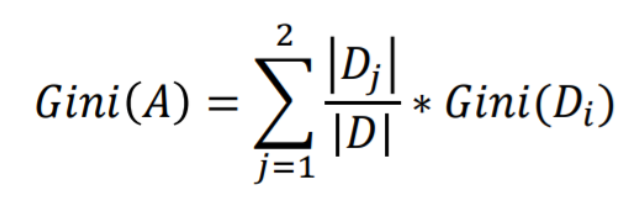

In [12]:
Image('get_attribute_gini_index.png') # get_attribute_gini_index 함수에 사용되는 공식

In [13]:
def get_attribute_gini_index(df, attribute, label):
    class_total = df[attribute]         # 변수의 전체 데이터
    class_uniq = df[attribute].unique() # 고유 클래스의 집합 (클래스가 하나뿐인 것은 무의미하기 때문에 길이가 2 이상이라 가정)

    bin_split = get_binary_split(df, attribute) # binary split된 조합 데이터

    result = {}
    gini = 0
    for elm in bin_split: # 각 split 항목에 대한 gini index를 구한다.
        included = np.isin(class_total,elm)            # elm을 포함 여부를 나타내는 Boolean index
        num_positive = len(included[included] == True) # elm 내용을 포함하는 데이터의 개수
        num_negative = len(class_total) - num_positive # elm 내용을 포함하지 않는 데이터의 개수
        
        # 위 공식에 맞게 계산한다.
        gini = (num_positive / len(class_total)) * get_gini(df.loc[included == True], label) + \
                (num_negative / len(class_total)) * get_gini(df.loc[included == False], label)
        result['_'.join(elm)] = gini
            
    return result

In [14]:
get_attribute_gini_index(pd_data, "age", "class_buys_computer")

{'youth': 0.3936507936507937,
 'middle_aged': 0.35714285714285715,
 'senior': 0.45714285714285713,
 'middle_aged_senior': 0.3936507936507937,
 'youth_senior': 0.35714285714285715,
 'youth_middle_aged': 0.45714285714285713}

여기서 가장 작은 Gini index값을 가지는 class를 기준으로 split해야겠죠?

In [15]:
min(get_attribute_gini_index(pd_data, "age", "class_buys_computer").items())

('middle_aged', 0.35714285714285715)

# 다음의 문제를 위에서 작성한 함수를 통해 구한 값으로 보여주세요!
## 문제1) 변수 ‘income’의 이진분류 결과를 보여주세요.

In [16]:
##문제1 답안
get_binary_split(pd_data, 'income')

[['high'],
 ['medium'],
 ['low'],
 ['medium', 'low'],
 ['high', 'low'],
 ['high', 'medium']]

## 문제2) 분류를 하는 데 가장 중요한 변수를 선정하고, 해당 변수의 Gini index를 제시해주세요.

In [17]:
##문제2 답안
gini_age           = min(get_attribute_gini_index(pd_data, "age", "class_buys_computer").items())
gini_income        = min(get_attribute_gini_index(pd_data, "income", "class_buys_computer").items())
gini_student       = min(get_attribute_gini_index(pd_data, "student", "class_buys_computer").items())
gini_credit_rating = min(get_attribute_gini_index(pd_data, "credit_rating", "class_buys_computer").items())

gini_age, gini_income, gini_student, gini_credit_rating

(('middle_aged', 0.35714285714285715),
 ('high', 0.4428571428571429),
 ('no', 0.3673469387755103),
 ('excellent', 0.42857142857142855))

> age 변수의 gini index가 0.35714285714285715 으로 가장 작기 때문에 가장 중요한 분류 변수로 선정된다. <br/>
따라서 최초 split 변수는 **age**이며, 그 기준은 **middle_aged**가 될 것이다.

## 문제3) 문제 2에서 제시한 feature로 DataFrame을 split한 후 나눠진 2개의 DataFrame에서 각각   다음으로 중요한 변수를 선정하고 해당 변수의 Gini index를 제시해주세요.

In [18]:
##문제3 답안

# middle_aged에 해당되는 DataFrame
being_split_1 = pd_data.loc[pd_data.age == 'middle_aged']

gini_income_1        = min(get_attribute_gini_index(being_split_1, "income", "class_buys_computer").items())
gini_student_1       = min(get_attribute_gini_index(being_split_1, "student", "class_buys_computer").items())
gini_credit_rating_1 = min(get_attribute_gini_index(being_split_1, "credit_rating", "class_buys_computer").items())

gini_income_1, gini_student_1, gini_credit_rating_1

(('high', 0.0), ('no', 0.0), ('excellent', 0.0))

> gini index가 모두 0으로 출력되었기 때문에 **최종적으로 분류된 노드**라고 판단하였다.

In [19]:
# middle_aged에 해당되지 않는 DataFrame
being_split_2 = pd_data.loc[pd_data.age != 'middle_aged']

gini_age_2           = min(get_attribute_gini_index(being_split_2, "age", "class_buys_computer").items())
gini_income_2        = min(get_attribute_gini_index(being_split_2, "income", "class_buys_computer").items())
gini_student_2       = min(get_attribute_gini_index(being_split_2, "student", "class_buys_computer").items())
gini_credit_rating_2 = min(get_attribute_gini_index(being_split_2, "credit_rating", "class_buys_computer").items())

gini_age_2, gini_income_2, gini_student_2, gini_credit_rating_2

(('senior', 0.48),
 ('high', 0.375),
 ('no', 0.31999999999999984),
 ('excellent', 0.4166666666666667))

> age[middle_aged]에 이어 두 번째로 중요한 변수는 0.31999999999999984의 gini index를 나타내는 student가 선정되었다. <br/>
따라서 다음 split은 **student**의 **no**를 기준으로 실행될 것이다.